# Keras LSTM benchmark notebook

This notebook explores a different type of model architecture that will capture feature values at previous time steps

In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [261]:
#untie local dependency
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + '\\data\\raw'
processed_data_path = local_repo_path + '\\data\\processed'
feature_path = local_repo_path + '\\data\\features'
submissions_path = local_repo_path + '\\submissions'

# Load data

In [262]:
output_feature_fname = 'keras'
sj_feature_train = pd.read_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv', index_col=0)
sj_feature_test = pd.read_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv', index_col=0)
iq_feature_train = pd.read_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv', index_col=0)
iq_feature_test = pd.read_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv', index_col=0)

In [263]:
sj_feature_train.head()

,0,1,2,3,4,total_cases
0,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,4
1,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,5
2,0.006304,-0.005017,-0.214395,0.000000,-0.530953,4
3,-0.061121,-0.053519,0.110260,0.227273,-0.510605,3
4,0.144991,0.146063,0.741194,0.500000,-0.479789,6


In [305]:
sj_feature_test.head()

,0,1,2,3,4,city,year,weekofyear
0,-0.350555,-0.359024,-0.294028,-0.500000,-0.542448,sj,2008,18
1,-0.399342,-0.410314,-0.490046,-0.272727,-0.541333,sj,2008,19
2,-0.060573,-0.054077,0.306279,0.000000,-0.530953,sj,2008,20
3,-0.405372,-0.407526,0.361409,0.727273,-0.510605,sj,2008,21
4,-0.266685,-0.268153,0.171516,0.227273,-0.479789,sj,2008,22


In [265]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [266]:
sj_feature_train.head()

,0,1,2,3,4,total_cases
0,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,4
1,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,5
2,0.006304,-0.005017,-0.214395,0.000000,-0.530953,4
3,-0.061121,-0.053519,0.110260,0.227273,-0.510605,3
4,0.144991,0.146063,0.741194,0.500000,-0.479789,6


In [267]:
X_tr_sj_wide.shape

(916, 101)

# Reshape with lookback features - and output data to features folder

Set lookback

In [315]:
n_lookback = 20

## Test SJ

In [316]:
X_test_sj_wide = sj_feature_train.drop('total_cases', axis = 1).iloc[-n_lookback:,:].append(sj_feature_test.drop(['city','weekofyear', 'year'], axis = 1)).reset_index(drop = True)
X_test_sj_wide = series_to_supervised(X_test_sj_wide, n_lookback, 1)
X_test_sj_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)
features_out = pd.DataFrame(X_test_sj_wide).reset_index(drop = True)
features_out['city'] = 'sj'
features_out['year'] = sj_feature_test['year']
features_out['weekofyear'] = sj_feature_test['weekofyear']
features_out.to_csv(feature_path + '\\sj_test_Lookback' + str(n_lookback) + '.csv')
X_test_sj_wide = X_test_sj_wide.values.reshape((X_test_sj_wide.shape[0], 1, X_test_sj_wide.shape[1]))
X_test_sj_wide.shape

(260, 1, 100)

## Train SJ

In [317]:
X_tr_sj_wide = series_to_supervised(sj_feature_train.drop('total_cases', axis = 1), n_lookback, 1)
X_tr_sj_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)
X_tr_sj_wide['total_cases'] = sj_feature_train['total_cases']
X_tr_sj_wide.to_csv(feature_path + '\\sj_train_Lookback' + str(n_lookback) + '.csv')
X_tr_sj_wide.shape

(916, 101)

## Test IQ

In [318]:
X_test_iq_wide = iq_feature_train.drop('total_cases', axis = 1).iloc[-n_lookback:,:].append(iq_feature_test.drop(['city','weekofyear', 'year'], axis = 1)).reset_index(drop = True)
X_test_iq_wide = series_to_supervised(X_test_iq_wide, n_lookback, 1)
X_test_iq_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)
features_out = pd.DataFrame(X_test_iq_wide).reset_index(drop = True)
features_out['city'] = 'iq'
features_out['year'] = iq_feature_test['year']
features_out['weekofyear'] = iq_feature_test['weekofyear']
features_out.to_csv(feature_path + '\\iq_test_Lookback' + str(n_lookback) + '.csv')
X_test_iq_wide = X_test_iq_wide.values.reshape((X_test_iq_wide.shape[0], 1, X_test_iq_wide.shape[1]))
X_test_iq_wide.shape

(156, 1, 100)

## Train IQ

In [319]:
X_tr_iq_wide = series_to_supervised(iq_feature_train.drop('total_cases', axis = 1), n_lookback, 1)
X_tr_iq_wide.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace = True)
X_tr_iq_wide['total_cases'] = iq_feature_train['total_cases']
X_tr_iq_wide.to_csv(feature_path + '\\iq_train_Lookback' + str(n_lookback) + '.csv')
X_tr_iq_wide.shape

(500, 101)

In [218]:
def fit_and_predict_LSTM(train_wide, test_wide, epochs = 1000, n_hidden = 25, activation = 'linear'):
    values = train_wide.values
    n_train = values.shape[0] - 50
    train = values[:n_train, :]
    val = values[n_train:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    
    plt.figure(figsize = (7,5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    #build predictions for figure
    test_preds = model.predict(test_wide)
    
    
    train_X_full = values[:,:-1]
    train_preds = model.predict(train_X_full.reshape((train_X_full.shape[0], 1, train_X_full.shape[1])))
    
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train_wide['total_cases']),1)
    pd.DataFrame(train_wide['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train_wide), len(train_wide)+ len(test_preds))).plot(ax = ax)
    pd.DataFrame(train_preds).plot(ax = ax)
    ax.legend(labels = ['True', 'Predicted', 'Fitted'])
    ax.set_title('Mean train error: ' + str(train_error))
    return(model, train_preds, test_preds)

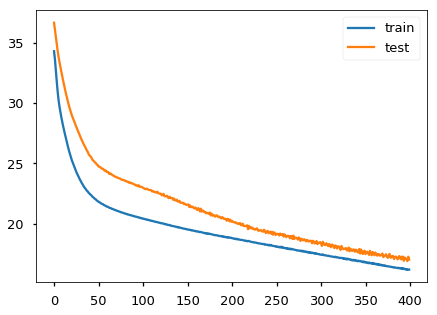

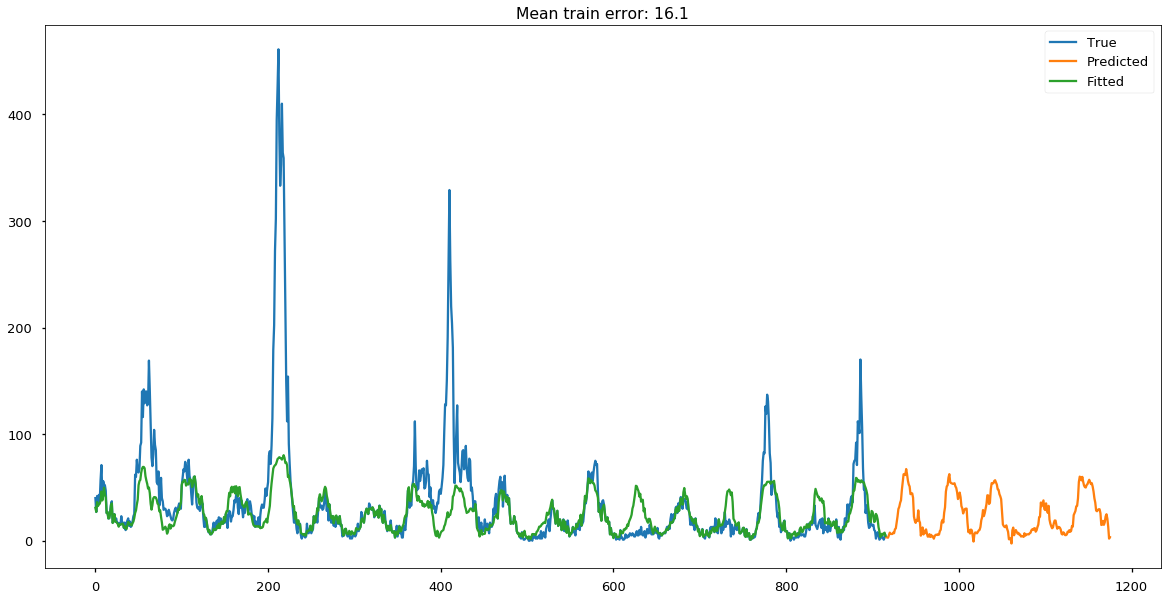

In [219]:
sj_model, sj_train_preds, sj_test_preds = fit_and_predict_LSTM(X_tr_sj_wide, X_test_sj_wide, epochs = 400, n_hidden = 100)

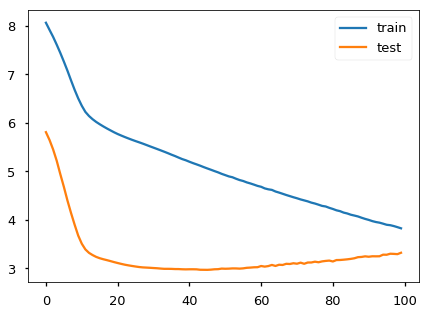

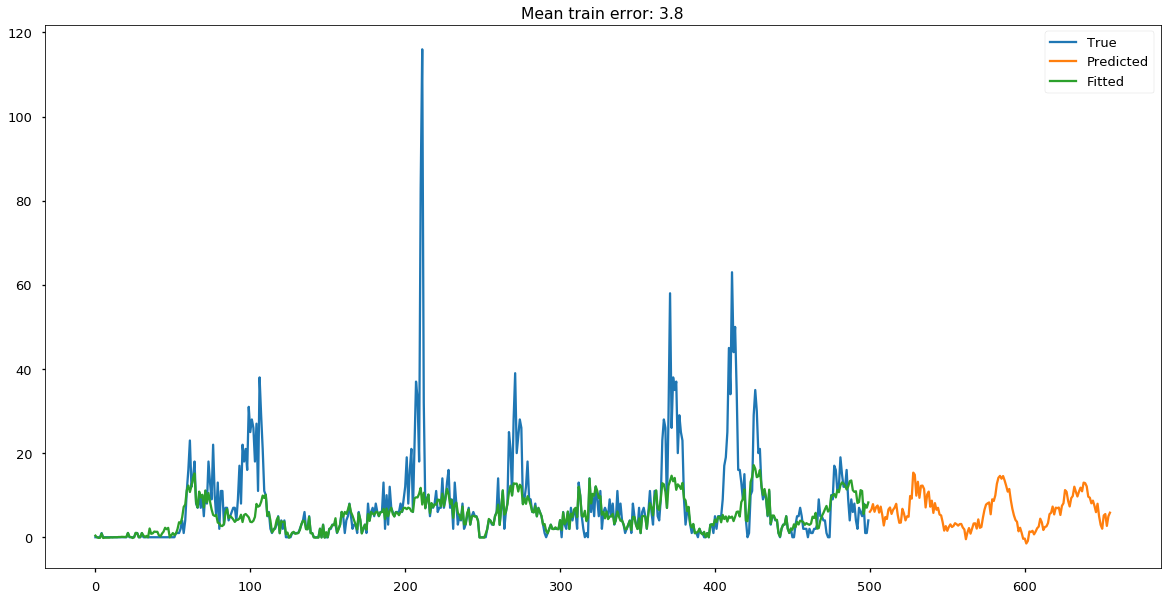

In [220]:
iq_model, iq_train_preds, iq_test_preds = fit_and_predict_LSTM(X_tr_iq_wide, X_test_iq_wide, epochs = 100, n_hidden = 100)

In [227]:
sj_sub = pd.DataFrame(sj_test_preds.astype(int), columns = ['total_cases'])
sj_sub['year'] = sj_feature_test['year']
sj_sub['weekofyear'] = sj_feature_test['weekofyear']
sj_sub['city'] = 'sj'

In [228]:
iq_sub = pd.DataFrame(iq_test_preds.astype(int), columns = ['total_cases'])
iq_sub['year'] = iq_feature_test['year']
iq_sub['weekofyear'] = iq_feature_test['weekofyear']
iq_sub['city'] = 'iq'

In [229]:
sub = sj_sub.append(iq_sub)[['city', 'year', 'weekofyear', 'total_cases']]

In [235]:
sub.loc[sub['total_cases'] < 0, 'total_cases'] = 0

In [237]:
sub.to_csv(submissions_path + 'Keras_LSTM1.csv', index = False)